/var/folders/lz/nlzcstbj3ns0khpcn06c2xgh0000gn/T/ipykernel_15645/562104897.py:49: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/train.csv')



✅ 최종 모델 학습: RandomForest (Best Params 적용)


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

🎯 최종 모델 Recall: 0.9427
📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.9974    0.9905    0.9939     13985
         1.0     0.8166    0.9427    0.8751       628

    accuracy                         0.9884     14613
   macro avg     0.9070    0.9666    0.9345     14613
weighted avg     0.9896    0.9884    0.9888     14613



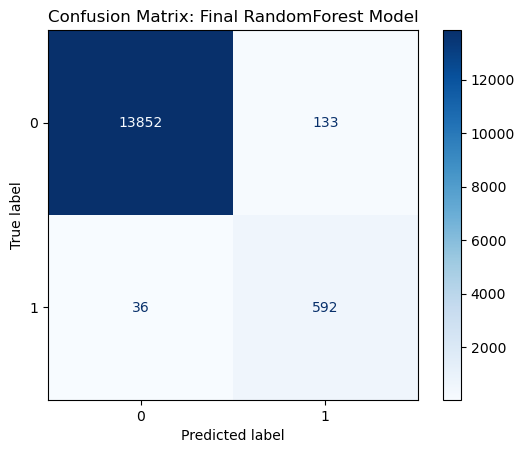

ModuleNotFoundError: No module named 'shap'

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False




plt.rcParams['font.family'] = 'NanumGothic'

class CustomCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=['mold_name', 'name', 'line',
                            'emergency_stop', 'count', 'tryshot_signal',
                            'upper_mold_temp3', 'lower_mold_temp3',
                            'molten_volume', 'time', 'date', 'heating_furnace'],errors='ignore')  # test셋에 없는 컬럼 있어도 대비
        X = X[~X['working'].isna()]
        X['registration_time'] = pd.to_datetime(X['registration_time'])
        X['EMS_operation_time'] = X['EMS_operation_time'].astype('object')
        X['mold_code'] = X['mold_code'].astype('object')
        X = X[~((X['molten_temp'] == 0) |
                (X['low_section_speed'] >= 60000) |
                (X['production_cycletime'] == 0) |
                (X['upper_mold_temp1'] >= 1449) |
                (X['sleeve_temperature'] >= 1449) |
                (X['physical_strength'] >= 60000) |
                (X['Coolant_temperature'] >= 1449) |
                (X['upper_mold_temp2'] >= 4000))]
        X['hour'] = X['registration_time'].dt.hour
        X = X.drop(columns=['registration_time']) 
        return X.reset_index(drop=True)

df = pd.read_csv('../data/train.csv')
X = df.drop(columns=['passorfail','id'])
y = df['passorfail']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
cleaner = CustomCleaner()

train_set = X_train.copy()
train_set['passorfail'] = y_train
train_set_clean = cleaner.fit_transform(train_set)
y_train = train_set_clean['passorfail']
X_train = train_set_clean.drop(columns=['passorfail'])

val_set = X_val.copy()
val_set['passorfail'] = y_val
val_set_clean = cleaner.transform(val_set)
y_val = val_set_clean['passorfail']
X_val = val_set_clean.drop(columns=['passorfail'])


num_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


final_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=4,
    max_depth=20,
    random_state=42
)

# 파이프라인 구성
final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', final_model)
])

# 학습
print("\n✅ 최종 모델 학습: RandomForest (Best Params 적용)")
final_pipeline.fit(X_train, y_train)

# 예측 및 평가
y_pred = final_pipeline.predict(X_val)
recall = recall_score(y_val, y_pred)

print(f"🎯 최종 모델 Recall: {recall:.4f}")
print("📊 Classification Report:")
print(classification_report(y_val, y_pred, digits=4))

# 혼동 행렬
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Final RandomForest Model')
plt.show()



#test로 정답지 확인
#total = pd.read_csv('./data/casting.csv', encoding='cp949',index_col=0)
#test = pd.read_csv('./data/test.csv')
#
#
#X_test = cleaner.transform(test)
#y_true = total.loc[X_test['id'], 'passorfail'].values
#y_pred = final_pipeline.predict(X_test)
#
#print(confusion_matrix(y_true, y_pred))
#print(classification_report(y_true, y_pred))


import shap
from sklearn.inspection import permutation_importance

# === 1. Permutation Importance ===
print("\n📌 Permutation Importance 계산 중...")
from sklearn.inspection import permutation_importance

# 전처리
X_val_transformed = final_pipeline.named_steps['preprocessor'].transform(X_val)

# Permutation Importance 계산
perm_result = permutation_importance(
    final_pipeline.named_steps['model'],
    X_val_transformed,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 정확한 피처 이름 추출
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 중요도 상위 20개 시각화
sorted_idx = perm_result.importances_mean.argsort()[::-1][:20]
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_result.importances_mean[sorted_idx])
plt.xlabel("Mean Permutation Importance")
plt.title("Top 20 Permutation Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === 2. SHAP 분석 ===

print("\n📌 SHAP 값 계산 중...")

import shap
import time

# 전체 검증 데이터로 SHAP 분석
X_val_processed = final_pipeline.named_steps['preprocessor'].transform(X_val)
X_val_processed.shape
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names)
X_val_df.shape

# 모델 준비
rf_model = final_pipeline.named_steps['model']

print("🔧 TreeExplainer 초기화 중...")
explainer = shap.TreeExplainer(rf_model)

start_time = time.time()
print("⏳ SHAP 값 계산 시작... (시간이 다소 걸릴 수 있습니다)")

shap_values = explainer.shap_values(X_val_df)
shap_values.shape

elapsed = time.time() - start_time
minutes = int(elapsed // 60)
seconds = int(elapsed % 60)
print(f"⏱️ SHAP 계산 완료! 소요 시간: {minutes}분 {seconds}초")

# 이진 분류인 경우 SHAP 값 처리
#if isinstance(shap_values, list) and len(shap_values) == 2:
#    shap_values_plot = shap_values[1]
#    print("✅ 이진 분류 - 양품 예측 SHAP 값 사용")
#else:
#    shap_values_plot = shap_values
#    print("✅ 단일 SHAP 값 사용")
shap_values.shape
shap_values_plot = shap_values[:, :, 1]
print(f"✅ SHAP 값 shape: {shap_values_plot.shape}")
print(f"✅ DataFrame shape: {X_val_df.shape}")


#shap feature importance
fig = plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_plot, X_val_df, plot_type="bar", show=False, max_display=20)
plt.title("SHAP Feature Importance (불량 예측 기준) - 상위 20개")
fig.subplots_adjust(left=0.3, right=0.95)  # 왼쪽/오른쪽 여백 확보
plt.show()
#shap summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_plot, X_val_df, show=False, max_display=20)
plt.title("SHAP Summary Plot (불량 예측 기준) - 상위 20개 변수 영향도 분포")
plt.tight_layout()
plt.show()

importance_df = pd.DataFrame({
    'feature': X_val_df.columns,
    'mean_abs_shap': np.abs(shap_values_plot).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

print(importance_df.head(20))


In [ ]:
test_X = pd.read_csv('../data/test.csv')
test_X2= cleaner.transform(test_X)
test_X2 = test_X2.drop(columns='id',axis=1)

sample = test_X2.iloc[[78]]  

prediction = final_pipeline.predict(sample)[0]
proba = final_pipeline.predict_proba(sample)[0][1]

print(f"예측 결과: {'불량' if prediction == 1 else '양품'}")
print(f"불량 확률: {proba:.4f}")